## Foraminiferal Ecogroup Biomass Production change

In [42]:
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cgeniepy.ecology import EcoModel

In [43]:
def group_biomass_production_ts(model_path):
    "foraminifera ecogroup biomass production time series"
    model = EcoModel(model_path)

    ## time and foram ecogroup to be loopped 
    time = model.get_var("time").array.values + 0.5
    foram_names = ["bn", "bs", "ss"]

    ## m3 in the first layer
    grid_volume = model.grid_volume().isel(zt=0)

    ## initialize data_all
    allforam_biomass = np.zeros((len(time), len(foram_names)))

    ## start loop
    for iforam in foram_names:
        iforam_biomass = []
        for iyear in range(len(time)):
            ## mmol C m-3
            foram_biomass = model.get_foram(iforam, 'HeteroUptake', 'C').isel(time=iyear)
            if iforam == 'sn' or iforam == 'ss':
                foram_biomass = foram_biomass + model.get_foram(iforam, 'AutoUptake', 'C').isel(time=iyear)
            
            foram_biomass = foram_biomass * grid_volume ## mmol C
            ## convert to Pg C
            foram_biomass_Pg = foram_biomass * 12 * 1E-3 * 1E-15

            global_Pg =  np.nansum(foram_biomass_Pg.array)

            ## store in list
            iforam_biomass.append(global_Pg)            
            
        ## >>>> finish one foram type
        ## >>>> convert to numpy array
        iforam_biomass = np.array(iforam_biomass)
        ## assign the data into the container    
        allforam_biomass[:, foram_names.index(iforam)] = iforam_biomass
        
    # ## add time
    allforam_biomass = np.hstack((time.reshape(-1, 1), allforam_biomass))
    # ## convert to dataframe
    allforam_biomass = pd.DataFrame(allforam_biomass, columns=["time", "symbiont-barren non-spinose", "symbiont-barren spinose", "symbiont-obligate spinose"])
    
    return allforam_biomass

In [44]:
## plot pre-industrial age to future
mod_paths = [
    "../model/muffin.CBE.worlg4.BASESFeTDTL.diag/",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.historical.diag",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.1p5deg.diag",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.2deg.diag",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.3deg.diag",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.4deg.diag",
]

## init a list to store data
biomass_data = []
for path in mod_paths:
    mod_group_biomass = group_biomass_production_ts(path)
    ## add group column based on model path
    if "GIteiiva" in path:
        mod_group_biomass["age"] = "LGM"
    elif "BASESFeTDTL.diag" in path:
        mod_group_biomass["age"] = "PI"
    elif "historical" in path:
        mod_group_biomass["age"] = "historical"
    elif "2100" in path:
        mod_group_biomass["age"] = "+"+path.split(".")[-2]
    biomass_data.append(mod_group_biomass)

## concat data
biomass_data = pd.concat(biomass_data)

## longer data format
biomass_data = pd.melt(biomass_data, id_vars=["time", "age"], var_name="foramtype", value_name="biomass")

No gemflag is provided, assuming the model includes biogem and ecogem
grid area returned in the unit of 'm2'
grid volume calculated in the unit of 'm3'
No gemflag is provided, assuming the model includes biogem and ecogem
grid area returned in the unit of 'm2'
grid volume calculated in the unit of 'm3'
No gemflag is provided, assuming the model includes biogem and ecogem
grid area returned in the unit of 'm2'
grid volume calculated in the unit of 'm3'
No gemflag is provided, assuming the model includes biogem and ecogem
grid area returned in the unit of 'm2'
grid volume calculated in the unit of 'm3'
No gemflag is provided, assuming the model includes biogem and ecogem
grid area returned in the unit of 'm2'
grid volume calculated in the unit of 'm3'
No gemflag is provided, assuming the model includes biogem and ecogem
grid area returned in the unit of 'm2'
grid volume calculated in the unit of 'm3'


In [45]:
## only use historical and future data
biomass_future = biomass_data.loc[(biomass_data['age'] != "PI") & (biomass_data['age'] != "LGM")]
biomass_future = biomass_future[biomass_future['time'] > 1900]

In [46]:
## plot time series of future run
biomass_future = biomass_data.loc[(biomass_data['age'] != "PI") & (biomass_data['age'] != "LGM")]
biomass_future = biomass_future[biomass_future['time'] > 1900]

## remove 2023 (ECOGEM no restart)
biomass_future = biomass_future[biomass_future['time'] != 2023]

## calculate relative biomass change
biomass_future = biomass_future.groupby("foramtype").apply(lambda g: g.assign(relative_change=g['biomass'] / g['biomass'].iloc[0] - 1))

biomass_future['relative_change'] = biomass_future['relative_change'] * 100

/var/folders/rq/vks10_qx2l9b08d_pygvwfzh0000gn/T/ipykernel_10467/2926649014.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  biomass_future = biomass_future.groupby("foramtype").apply(lambda g: g.assign(relative_change=g['biomass'] / g['biomass'].iloc[0] - 1))


In [47]:
## copy the last year of historical to the starting point of future scenarios (only for plotting)
historical_2022 = biomass_future[(biomass_future['age'] == 'historical') & (biomass_future['time'] == 2022)]

result = pd.DataFrame()

# Iterate over unique age categories and append modified rows to result DataFrame
for age_category in biomass_future['age'].unique():
    if age_category != 'historical' and age_category != 'pre-industrial':
        modified_df = historical_2022.copy()
        modified_df['age'] = age_category
        result = pd.concat([result, modified_df], ignore_index=True)

biomass_future = pd.concat([biomass_future, result])    

In [48]:
biomass_future = biomass_future.replace("+1p5deg", "1.5 °C")
biomass_future = biomass_future.replace("+2deg", "2 °C")
biomass_future = biomass_future.replace("+3deg", "3 °C")
biomass_future = biomass_future.replace("+4deg", "4 °C")

/Users/yingrui/miniforge3/envs/workspace/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/yingrui/miniforge3/envs/workspace/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/yingrui/miniforge3/envs/workspace/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

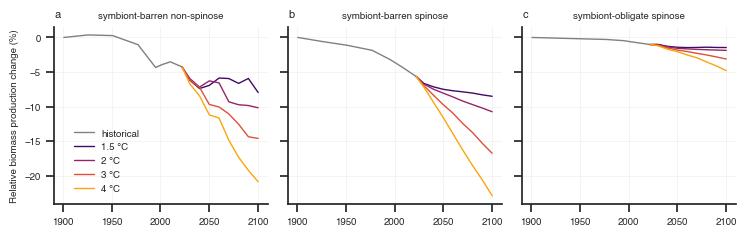

In [51]:
def set_theme(base_size=7, base_family="helvetica"):

    custom_params = {
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.grid": True,
        "grid.color": "#f0f0f0",
        "grid.linewidth": 0.5,
        'lines.linewidth': 1.0,
        'legend.frameon': False,
    }

    sns.set_theme(context='notebook', style='ticks', font=base_family, rc=custom_params)


    font = {
        'family': base_family,
        'weight': 'bold',
        'size': base_size
    }

    plt.rc('font', **font)

    params = {
        'axes.labelsize': base_size,
        'axes.titlesize': base_size,
        'xtick.labelsize': base_size,
        'ytick.labelsize': base_size
    }
    plt.rcParams.update(params)

set_theme(base_size=7)

reds_palette = sns.color_palette("inferno", n_colors=4).as_hex()
# Add grey as the first color in the palette
custom_palette = ["#808080"] + reds_palette

# Create a FacetGrid using seaborn.relplot()
with sns.plotting_context(rc={"legend.fontsize":7}):
    g = sns.relplot(
        data=biomass_future,
        x='time',
        y='relative_change',
        hue='age',
        kind='line',
        markers=True,
        col='foramtype', 
        col_wrap=3,
        height=2.5,
        palette=custom_palette,
        
    )

g._legend.set_title("")
g._legend.set_bbox_to_anchor([0.18,0.3])


   
## add letter
# Set axis labels and plot title
g.set_axis_labels('', 'Relative biomass production change (%)')

g.set_titles("{col_name}",fontsize=7)

# Add subplot labels (a, b, c, ...)
for ax, label in zip(g.axes.flat, ["a", "b", "c"]):
    ax.text(0, 1.1, label, transform=ax.transAxes, fontweight='bold', 
            fontsize=8, va='top', ha='left')
## save figure
g.savefig('../output/ext_figx.jpg', dpi=300)